In [156]:
'''
1. When looking for the optimal k,random_state = 101
2. using the optimal k from step 1. get the average mean RMSE from 21 random cases, where random_state = range(1,102,5)
'''


import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_squared_error
%matplotlib inline
import math as m
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix
pd.set_option("display.precision", 8)
import scipy.stats

from sklearn import svm
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.svm import SVC

from sklearn.cluster import KMeans

def indexlist(data):
    '''use indeces to mark the 143 gps coordinates'''
    checklist = data['ref_x'].unique()
    for i in range(len(checklist)):
        data['point_index'] = data['point_index'].replace([checklist[i]],i)
    return data

def cluster(rsrp,num = 3,delete_tiny = False):
    data = pd.read_csv('rds-SRSRP.csv').set_axis([0,1,2,3,4,5,6,7], axis=1)
    dataset = data.to_numpy()
    cluster = dataset.argsort()[:,-num:]
    cluster.sort()
    cluster_sum = []
    for row in cluster:
        sorted_cluster = ''
        for item in row:
            sorted_cluster += str(item)
        cluster_sum.append(sorted_cluster)
    cluster_df = pd.DataFrame(cluster_sum)
    #
    #cluster_checklist = np.unique(cluster_sum)
    cluster_checklist = cluster_df.value_counts().index.values
    

    #get the number of samples in each n-signal cluster
    cluster_size = cluster_df.value_counts().values
    #get the indeces of big clusters and tiny clusters
    tiny_cluster_index, big_cluster_index = np.where(cluster_size<20)[0], np.where(cluster_size>=20)[0]
    #the replace list=[[big_cluster_indeces],[np.ones(length of tiny cluster indeces)]*the first attribute of the tiny _cluster_index]
    if delete_tiny == False:
        try:
            replace_list = np.append(range(len(big_cluster_index)),np.ones(len(tiny_cluster_index),dtype = int)*tiny_cluster_index[0])
        except:
            replace_list = range(len(big_cluster_index))
        rsrp['cluster'] = cluster_df.replace(cluster_checklist,replace_list)
        return rsrp
    else:
        '''drop tiny clusters'''
        tiny_index = np.array([])
        for i in range(len(big_cluster_index),len(big_cluster_index)+len(tiny_cluster_index)):
            tiny_index = np.append(tiny_index,np.where(cluster_df==cluster_checklist[i])[0])
        replace_list = np.append(range(len(big_cluster_index)),np.ones(len(tiny_cluster_index),dtype = int)*tiny_cluster_index[0])
        rsrp['cluster'] = cluster_df.replace(cluster_checklist,replace_list)
        return rsrp,tiny_index

def rsrp_indexlist(data):
    '''use indeces to mark the 41 rsrp clusters, where the cluster is categorized by the 3 largest signals'''
    checklist = data['cluster'].unique()
    for i in range(len(checklist)):
        data['rsrp_cluster'] = data['rsrp_cluster'].replace(checklist[i],i)
    return data

def knn(data,gps,n_neighbors=10):
    scaler = StandardScaler()
    scaler.fit(data)
    scaled_features = scaler.transform(data)
    df_feat = pd.DataFrame(scaled_features,columns=data.columns)
    X_train, X_test, y_train, y_test = train_test_split(scaled_features,gps['point_index'],
                                                        test_size=0.20,random_state=101)
    knn_model = KNeighborsClassifier(n_neighbors)
    knn_model.fit(X_train,y_train)
    pred = knn_model.predict(X_test)
    accuracy = np.mean(pred == y_test)
    #print(classification_report(y_test,pred))
    return np.array([pred]),np.array([y_test])
    
    
def knn_manhattan(data,k=5,state = 101,clustering = True,manhattan = True):
    '''Using Lin's idea '''
    '''try&if: using cluster method
       except&else: using non-cluster method
    '''
    if clustering == True:
        X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:8],data.iloc[:,-2:],
                                                        test_size=0.20,random_state=state)
    else:
        X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:8],data.iloc[:,-1],
                                                        test_size=0.20,random_state=state)
    pred_rec = []

    for i in range(len(y_test)):
        try:
            # get the cluster index
            sample_cluster = y_test.iloc[i,0]
            y_train_chosen = y_train[y_train['cluster'] == sample_cluster]
            chosen_indeces = y_train_chosen.index.values
            #get the norm-1 distance
            if manhattan == True:
                distances = np.dot(np.abs(X_train.loc[chosen_indeces] - X_test.iloc[i]),np.ones(8))
            else:
                distances = np.sqrt(np.sum(np.square(X_train.loc[chosen_indeces] - X_test.iloc[i]),axis=1)).values
            nn_ids = distances.argsort()[:k]
            nn_index = y_train_chosen.iloc[nn_ids,1]
        except:
            if manhattan == True:
                distances = np.dot(np.abs(X_train - X_test.iloc[i]),np.ones(8))
            else:
                distances = np.sqrt(np.sum(np.square(X_train - X_test.iloc[i]),axis=1)).values
            
            nn_ids = distances.argsort()[:k]
            nn_index = y_train.iloc[nn_ids]
        predi = int(scipy.stats.mode(nn_index)[0][0])
        pred_rec.append(predi)
    try:
        return np.array([pred_rec]),np.array([y_test.iloc[:,-1]])
    except:
        return np.array([pred_rec]),np.array([y_test])

def knn_reg_manhattan(data,k=19,state=101,clustering = True,manhattan = True):
    '''in wknn, get weighted average of all k nearest nighbours is worse than average of only 4 top-count neighbours(n=4)'''
    if clustering == True:
        X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:8],data.iloc[:,-2:],
                                                        test_size=0.20,random_state=state)
    else:
        X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:8],data.iloc[:,-1],
                                                        test_size=0.20,random_state=state)
    test = gps.iloc[y_test.index]
    test_ = np.array(list(zip(test.ref_x, test.ref_y)))
    pred_rec = []
    for i in range(len(y_test)):
        try:
            # get the cluster index
            sample_cluster = y_test.iloc[i,0]
            y_train_chosen = y_train[y_train['cluster'] == sample_cluster]
            chosen_indeces = y_train_chosen.index.values
            #get the norm-1 distance
            if manhattan == True:
                distances = np.dot(np.abs(X_train.loc[chosen_indeces] - X_test.iloc[i]),np.ones(8))
            else:
                distances = np.sqrt(np.sum(np.square(X_train.loc[chosen_indeces] - X_test.iloc[i]),axis=1)).values
            nn_ids = distances.argsort()[:k]
            nn_index = y_train_chosen.iloc[nn_ids,1]
        except:
            if manhattan == True:
                distances = np.dot(np.abs(X_train - X_test.iloc[i]),np.ones(8))
            else:
                distances = np.sqrt(np.sum(np.square(X_train - X_test.iloc[i]),axis=1)).values
            nn_ids = distances.argsort()[:k]
            nn_index = y_train.iloc[nn_ids]
        indeces = nn_index.value_counts().index[:4]
        counts = nn_index.value_counts().values[:4]
        #indeces = nn_index.value_counts().index
        #counts = nn_index.value_counts().values
        try:
            values = []
            for i in range(4):
                values.append(np.array(checklist.iloc[int(indeces[i])][0]))
            values = np.array(values)
            pred_i = np.dot(values.T,counts.T)/counts.sum()
        # if the location number < 3, choose the location with the highest counts
        except:
            pred_i = checklist.iloc[int(indeces[0])][0]
        pred_rec.append(pred_i)
    pred_ = np.array(pred_rec)
    se_rec = []
    for i in range(len(test)):
        lon_pred, lat_pred = pred_[i]
        lon_, lat_ = test_[i]
        err_lon = lon_pred - lon_
        err_lat = lat_pred -lat_
        err_x = err_lon*((40000/360)*1000*m.cos(lat_pred))
        err_y = err_lat*((40000/360)*1000)
        se = err_x**2 + err_y**2
        se_rec.append(se)
    return se_rec


def error_record(y_p,y_,checklist,se_rec):
    lon_pred, lat_pred = checklist.iloc[y_p][0]
    lon_, lat_ = checklist.iloc[y_][0]
    err_lon = lon_pred - lon_
    err_lat = lat_pred -lat_
    err_x = err_lon*((40000/360)*1000*m.cos(lat_pred))
    err_y = err_lat*((40000/360)*1000)
    se = err_x**2 + err_y**2
    se_rec.append(se)

def result_report(se_rec,test,verbose = False):
    rmse = np.sqrt(sum(se_rec)/len(test))
    a = np.sqrt(se_rec)
    #reshape b from (1,1116) to (1116)
    b = np.sort(a.T).flatten()
    err_80 = b[int(len(a)*0.8)]
    if verbose == True:
        print("RMSE is {:.2f}m".format(rmse))
        print("When the accuracy is 80%,RMSE is {:.2f}m".format(b[int(len(a)*0.8)]))
    return rmse,err_80

def give_result(result,checklist):
    try:
        se_rec = []
        pred = np.array(result.pred)
        test = np.array(result.test)
        for i in range(len(result.test)):
            y_ = int(test[i])
            y_p = int(pred[i])
            if y_ == y_p:
                se = 0
                se_rec.append(se)
            else:
                error_record(y_p,y_,checklist,se_rec)
        rmse,err_80 = result_report(se_rec,test)
    except:
        rmse = np.sqrt(np.mean(result.error))
        a = np.sqrt(result)
        b = np.sort(a.T).flatten()
        err_80=b[int(len(a)*0.8)]
    return rmse,err_80

In [157]:
rsrp = pd.read_csv('rds-SRSRP.csv')
gps = pd.read_csv("gps.csv")
gps['point_index'] = gps['ref_x']
gps['coordinate'] =  list(zip(gps.ref_x, gps.ref_y))
#input indeces for each individual gps coordinates
gps['point_index'] = gps['ref_x']
gps = indexlist(gps)
checklist = pd.DataFrame(gps.coordinate.unique(),columns = ['coordinate'])

#cluster by the 3 largest value
"""method 1: combine all the tiny clusters into the last cluster"""
'''
rsrp = cluster(rsrp,num = 3,delete_tiny=False)
feature = pd.concat([rsrp, gps['point_index']],axis = 1)
cluster_number = len(rsrp['cluster'].unique())
'''

'''method 2: num=3 delete all the tiny clusters and reindex the dataset'''
'''
rsrp,tiny_index = cluster(rsrp,num = 3,delete_tiny=True)
feature = feature = pd.concat([rsrp, gps['point_index']],axis = 1)
feature = feature.drop(index = tiny_index)
cluster_number = len(rsrp['cluster'].unique())
'''


'''method 3: num=2 delete all the tiny clusters and reindex the dataset'''
rsrp,tiny_index = cluster(rsrp,num = 2,delete_tiny=True)
feature = feature = pd.concat([rsrp, gps['point_index']],axis = 1)
feature = feature.drop(index = tiny_index)
cluster_number = len(rsrp['cluster'].unique())


In [158]:
feature.isna().index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            5561, 5562, 5563, 5564, 5565, 5566, 5567, 5568, 5569, 5570],
           dtype='int64', length=5529)

In [149]:
#Ex.0-1-0 knn
prediction,test = knn(rsrp.iloc[:,:8],gps,n_neighbors=5)
df = np.append(prediction, test,axis=0)
result = pd.DataFrame(df.T,columns = ['pred','test'])

#report
rmse,err_80 = give_result(result,checklist)
print("The accuracy is {:.2f}%".format(np.mean(result.pred == result.test)*100))
print("RMSE is {:.2f}m".format(rmse))
print("When the accuracy is 80%,RMSE is {:.2f}m".format(err_80))

The accuracy is 40.00%
RMSE is 9.48m
When the accuracy is 80%,RMSE is 11.12m


In [145]:
#Ex.0-1-1 knn,k=5
'''in knn euclidean distance is better'''
prediction, test = knn_manhattan(feature,k=1,clustering=False,manhattan=True)
df = np.append(prediction, test,axis=0)
result = pd.DataFrame(df.T,columns = ['pred','test'])
#report
rmse,err_80 = give_result(result,checklist)
print("Using manhattan, the accuracy is {:.2f}%".format(np.mean(result.pred == result.test)*100))
print("RMSE is {:.2f}m".format(rmse))
print("When the accuracy is 80%,RMSE is {:.2f}m".format(err_80))

#Ex.1-1-2 knn,k=5
'''in knn euclidean distance is better'''
prediction, test = knn_manhattan(feature,k=1,clustering=False,manhattan=False)
df = np.append(prediction, test,axis=0)
result = pd.DataFrame(df.T,columns = ['pred','test'])
#report
rmse,err_80 = give_result(result,checklist)
print("Using Euclidean, the accuracy is {:.2f}%".format(np.mean(result.pred == result.test)*100))
print("RMSE is {:.2f}m".format(rmse))
print("When the accuracy is 80%,RMSE is {:.2f}m".format(err_80))

Using manhattan, the accuracy is 39.01%
RMSE is 9.67m
When the accuracy is 80%,RMSE is 11.55m
Using Euclidean, the accuracy is 40.20%
RMSE is 9.72m
When the accuracy is 80%,RMSE is 12.17m


In [144]:
#Ex.0-2 knn find optimal k 
acc_rec = []
rmse_rec = []
err_80_rec = []
for k in range(1,31):
    prediction, test = knn_manhattan(feature,k=k,clustering=False,manhattan=False)
    df = np.append(prediction, test,axis=0)
    result = pd.DataFrame(df.T,columns = ['pred','test'])
    rmse,err_80 = give_result(result,checklist)
    acc_rec.append(np.mean(result.pred==result.test))
    rmse_rec.append(rmse)
    err_80_rec.append(err_80)
print('When k = {}, the highest accuracy is {:.2f}%'.format(np.argmax(acc_rec)+1,np.max(acc_rec)*100))
print('When k = {}, the lowest RMSE is {:.2f}m'.format(np.argmin(rmse_rec)+1,np.min(rmse_rec)))
print("When the accuracy is 80%,RSE is {:.2f}m".format(err_80_rec[np.argmin(rmse_rec)]))

When k = 1, the highest accuracy is 40.20%
When k = 1, the lowest RMSE is 9.72m
When the accuracy is 80%,RSE is 12.17m


In [150]:
#Ex.1-1 knn clustering ,k=1

prediction, test = knn_manhattan(feature,k=1,manhattan=True)
df = np.append(prediction, test,axis=0)
result = pd.DataFrame(df.T,columns = ['pred','test'])

#report
rmse,err_80 = give_result(result,checklist)
print("Using manhattan, the accuracy is {:.2f}%".format(np.mean(result.pred == result.test)*100))
print("RMSE is {:.2f}m".format(rmse))
print("When the accuracy is 80%,RMSE is {:.2f}m".format(err_80))

#Ex.1-1 knn clustering ,k=1

prediction, test = knn_manhattan(feature,k=1,manhattan=False)
df = np.append(prediction, test,axis=0)
result = pd.DataFrame(df.T,columns = ['pred','test'])

#report
rmse,err_80 = give_result(result,checklist)
print("Using Euclidean, the accuracy is {:.2f}%".format(np.mean(result.pred == result.test)*100))
print("RMSE is {:.2f}m".format(rmse))
print("When the accuracy is 80%,RMSE is {:.2f}m".format(err_80))

Using manhattan, the accuracy is 37.99%
RMSE is 9.82m
When the accuracy is 80%,RMSE is 12.31m
Using Euclidean, the accuracy is 38.45%
RMSE is 9.99m
When the accuracy is 80%,RMSE is 12.63m


In [151]:
#Ex.1-2 knn clustering find optimal k 
acc_rec = []
rmse_rec = []
err_80_rec = []
for k in range(1,21):
    prediction, test = knn_manhattan(feature,k = k,manhattan=False)
    df = np.append(prediction, test,axis=0)
    result = pd.DataFrame(df.T,columns = ['pred','test'])
    rmse,err_80 = give_result(result,checklist)
    acc_rec.append(np.mean(result.pred==result.test))
    rmse_rec.append(rmse)
    err_80_rec.append(err_80)
print('When k = {}, the highest accuracy is {:.2f}%'.format(np.argmax(acc_rec)+1,np.max(acc_rec)*100))
print('When k = {}, the lowest RMSE is {:.2f}m'.format(np.argmin(rmse_rec)+1,np.min(rmse_rec)))
print("When the accuracy is 80%,RSE is {:.2f}m".format(err_80_rec[np.argmin(rmse_rec)]))

When k = 1, the highest accuracy is 38.45%
When k = 1, the lowest RMSE is 9.99m
When the accuracy is 80%,RSE is 12.63m


In [153]:
#Ex.2-1 knn regression,k=19
result = pd.DataFrame(knn_reg_manhattan(feature,k=17,clustering=False,manhattan=True),columns = ['error'])
rmse,err_80 = give_result(result,checklist)
print("Using manhattan, RMSE is {:.2f}m".format(rmse))
print("When the accuracy is 80%,RMSE is {:.2f}m".format(err_80))

#Ex.2-2 knn regression,k=19
result = pd.DataFrame(knn_reg_manhattan(feature,k=17,clustering=False,manhattan=False),columns = ['error'])
rmse,err_80 = give_result(result,checklist)
print("Using Euclidean, RMSE is {:.2f}m".format(rmse))
print("When the accuracy is 80%,RMSE is {:.2f}m".format(err_80))

Using manhattan, RMSE is 7.83m
When the accuracy is 80%,RMSE is 9.45m
Using Euclidean, RMSE is 8.03m
When the accuracy is 80%,RMSE is 9.67m


In [152]:
#Ex.2-2 knn reg.  find optimal k
rmse_rec = []
err_80_rec = []
for k in range (1,31):
    result = pd.DataFrame(knn_reg_manhattan(feature,k=k,clustering=False),columns = ['error'])
    rmse,err_80 = give_result(result,checklist)
    rmse_rec.append(rmse)
    err_80_rec.append(err_80)
print('When k = {}, the lowest RMSE is {:.2f}m.'.format(np.argmin(rmse_rec)+1,np.min(rmse_rec)))
print("When the accuracy is 80%,RSE is {:.2f}m.".format(err_80_rec[np.argmin(rmse_rec)]))

When k = 17, the lowest RMSE is 7.83m.
When the accuracy is 80%,RSE is 9.45m.


Text(0, 0.5, 'error')

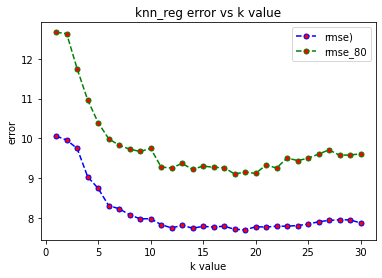

In [15]:
#knn, plot(k)
plt.plot(range(1,31),rmse_rec,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=5,label='rmse)')
plt.plot(range(1,31),err_80_rec,color='green', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=5,label='rmse_80')
plt.legend()
plt.title('knn_reg error vs k value')
plt.xlabel('k value')
plt.ylabel('error')

In [32]:
#Ex.2-3 knn reg. gets the mean RMSE for 21 random states
rmse_rec = []
err_80_rec = []
for state in range(1,102,5):
    #wknn regression with clustering
    result = pd.DataFrame(knn_reg_manhattan(data_sub,k=13,state = state),columns = ['error'])
    rmse = np.sqrt(np.mean(result.error))
    rmse_rec.append(rmse)
    #reshape b from (1,1116) to (1116)
    a = np.sqrt(result)
    b = np.sort(a.T).flatten()
    err_80=b[int(len(a)*0.8)]
    err_80_rec.append(err_80)
    #print("RMSE is {:.2f}m".format(rmse))
    #print("When the accuracy is 80%,RMSE is {:.2f}m".format(b[int(len(a)*0.8)]))
print('knn regression')
print('The RMSE is {:.2f}m; the 80% error is {:.2f}m.'.format(np.mean(rmse_rec),np.mean(err_80_rec)))

The RMSE is 7.28m; the 80% error is 8.87m.


In [155]:
#Ex.3-1-1 knn regression  with clustering,k=8
result = pd.DataFrame(knn_reg_manhattan(feature,k=12,manhattan=True),columns = ['error'])
rmse,err_80 = give_result(result,checklist)
print("Using manhattan, RMSE is {:.2f}m".format(rmse))
print("When the accuracy is 80%,RMSE is {:.2f}m".format(err_80))

#Ex.3-1-2 knn regression  with clustering,k=8
result = pd.DataFrame(knn_reg_manhattan(feature,k=12,manhattan=False),columns = ['error'])
rmse,err_80 = give_result(result,checklist)
print("Using Euclidean, RMSE is {:.2f}m".format(rmse))
print("When the accuracy is 80%,RMSE is {:.2f}m".format(err_80))

Using manhattan, RMSE is 8.35m
When the accuracy is 80%,RMSE is 9.96m
Using Euclidean, RMSE is 8.46m
When the accuracy is 80%,RMSE is 10.43m


In [154]:
#Ex.3-2 knn regression  with clustering find optimal k
rmse_rec = []
err_80_rec = []
for k in range (1,31):
    result = pd.DataFrame(knn_reg_manhattan(feature,k=k),columns = ['error'])
    rmse,err_80 = give_result(result,checklist)
    rmse_rec.append(rmse)
    err_80_rec.append(err_80)
print('When k = {}, the lowest RMSE is {:.2f}m.'.format(np.argmin(rmse_rec)+1,np.min(rmse_rec)))
print("When the accuracy is 80%,RSE is {:.2f}m.".format(err_80_rec[np.argmin(rmse_rec)]))

When k = 12, the lowest RMSE is 8.35m.
When the accuracy is 80%,RSE is 9.96m.


In [25]:
#Ex.3-2 knn reg. clustering find optimal k
rmse_rec = []
err_80_rec = []
for k in range (1,31):
    #knn regression  with clustering
    result = pd.DataFrame(columns = ['error'])
    for i in range(8):
        #data0 = feature[feature['rsrp_cluster']==i]
        data_sub = feature[feature['cluster']==i]
        value = data_sub.iloc[:,:8]
        label = data_sub.iloc[:,-1]
        result = result.append(pd.DataFrame(knn_reg_manhattan(data_sub,k),columns = ['error']))
    rmse = np.sqrt(np.mean(result.error))
    a = np.sqrt(result)
    b = np.sort(a.T).flatten()
    err_80=b[int(len(a)*0.8)]
    rmse_rec.append(rmse)
    err_80_rec.append(err_80)
print('When k = {}, the lowest RMSE is {:.2f}m.'.format(np.argmin(rmse_rec)+1,np.min(rmse_rec)))
print("When the accuracy is 80%,RSE is {:.2f}m.".format(err_80_rec[np.argmin(rmse_rec)]))

When k = 13, the lowest RMSE is 8.11
When the accuracy is 80%,RSE is 4.84m


In [23]:
#Ex.3-3 knn reg. clustering gets the mean RMSE for 21 random states
rmse_rec = []
err_80_rec = []
for state in range(1,102,5):
    #wknn regression with clustering
    result  = pd.DataFrame(columns = ['error'])
    for i in range(8):
        data_sub = feature[feature['cluster']==i]
        value = data_sub.iloc[:,:8]
        label = data_sub.iloc[:,-1]
        result = result.append(pd.DataFrame(knn_reg_manhattan(data_sub,k=13,state=state),columns = ['error']))
    rmse = np.sqrt(np.mean(result.error))
    rmse_rec.append(rmse)
    #reshape b from (1,1116) to (1116)
    a = np.sqrt(result)
    b = np.sort(a.T).flatten()
    err_80=b[int(len(a)*0.8)]
    err_80_rec.append(err_80)
    #print("RMSE is {:.2f}m".format(rmse))
    #print("When the accuracy is 80%,RMSE is {:.2f}m".format(b[int(len(a)*0.8)]))
print('knn regression clustering')
print('The RMSE is {:.2f}m; the 80% error is {:.2f}m.'.format(np.mean(rmse_rec),np.mean(err_80_rec)))

The RMSE is 8.18m; the 80% error is 9.75m.


Text(0, 0.5, 'error')

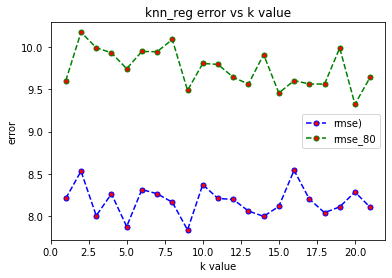

In [24]:
#knn, plot
plt.plot(range(1,22),rmse_rec,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=5,label='rmse)')
plt.plot(range(1,22),err_80_rec,color='green', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=5,label='rmse_80')
plt.legend()
plt.title('knn_reg error vs k value')
plt.xlabel('k value')
plt.ylabel('error')